In [60]:
import pickle

# Data wrangling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipelines to treat future data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Model selection and validation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pre-processing to include in PipeLine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Keep sklearn processing output as pandas datraframe
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    }
    
    return dict_metrics

In [3]:
data_location = '../data/insurance.csv'
df = pd.read_csv(data_location)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='age', ylabel='charges'>

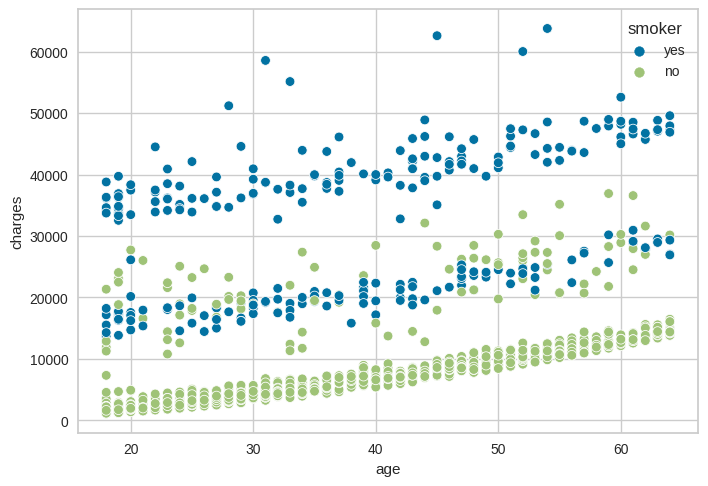

In [6]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

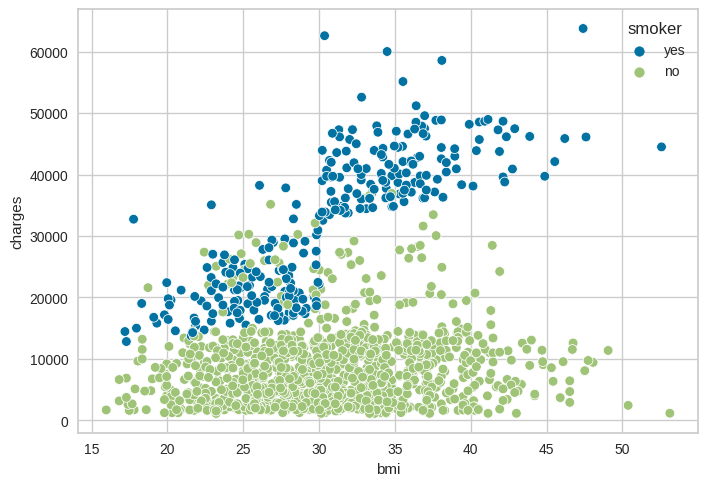

In [7]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

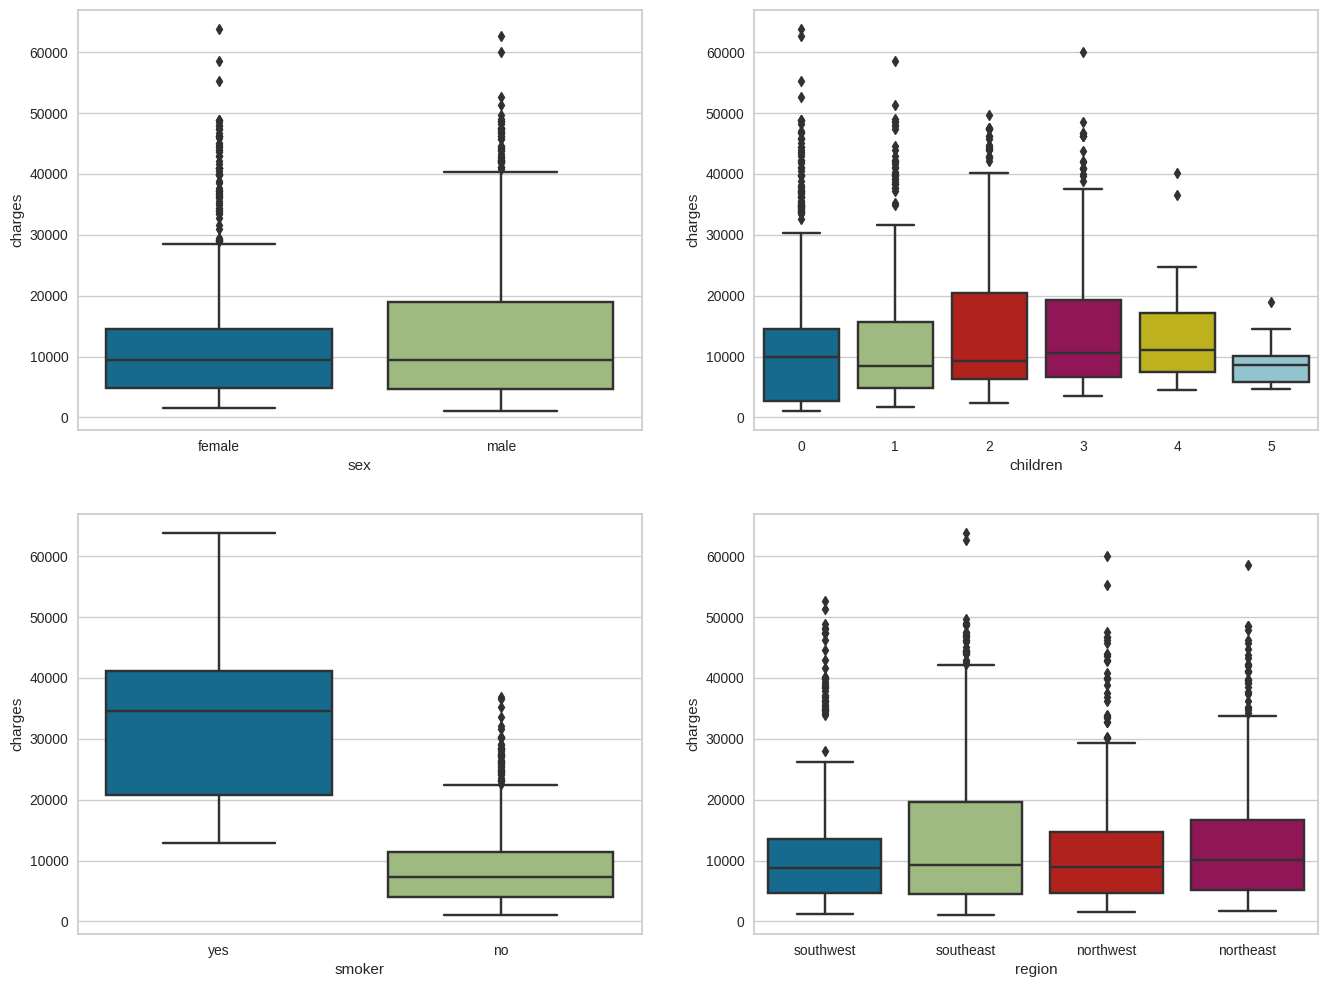

In [8]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
for col, ax in zip(cat_plot_cols, axes.flatten()):
    sns.boxplot(x=col, y='charges', data=df, ax=ax)

In [9]:
df.corr()

/tmp/ipykernel_102635/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


/tmp/ipykernel_102635/988216150.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones(df.corr().shape, dtype=bool))
/tmp/ipykernel_102635/988216150.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", annot_kws={"size": 5},
/home/lopes/miniconda3/envs/mlops/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


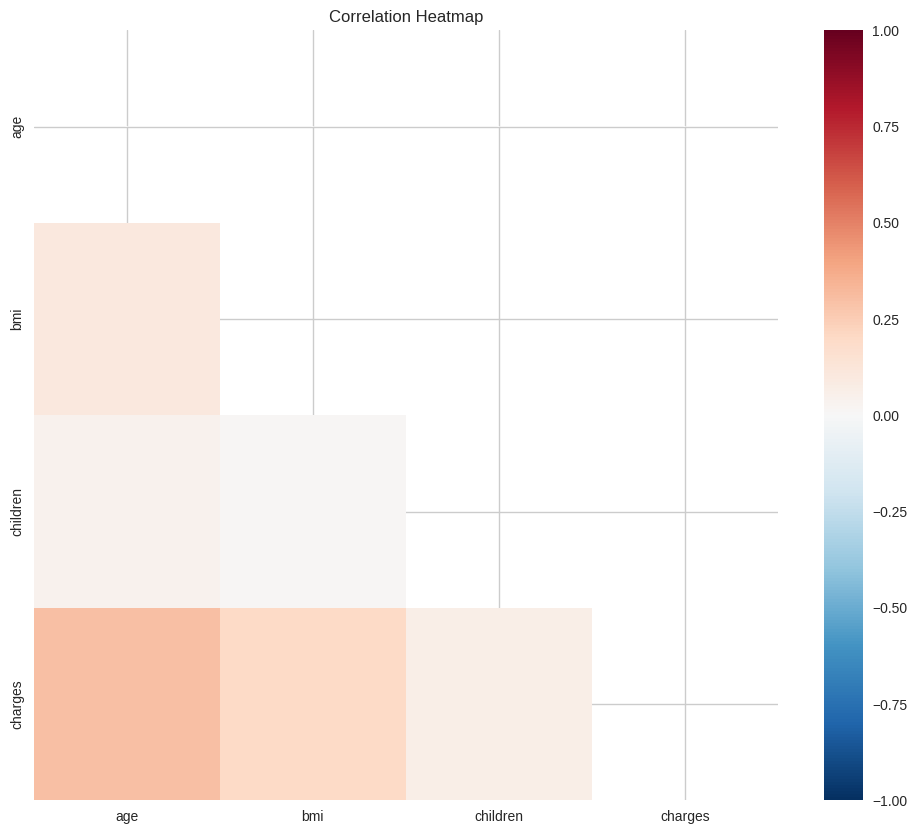

In [10]:
# Create a mask for the upper triangle
mask = np.triu(np.ones(df.corr().shape, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask
sns.heatmap(df.corr(), annot=True, fmt=".2f", annot_kws={"size": 5}, 
            mask=mask, cmap="RdBu_r", center=0, vmax=1, vmin=-1)


# Title of the heatmap
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

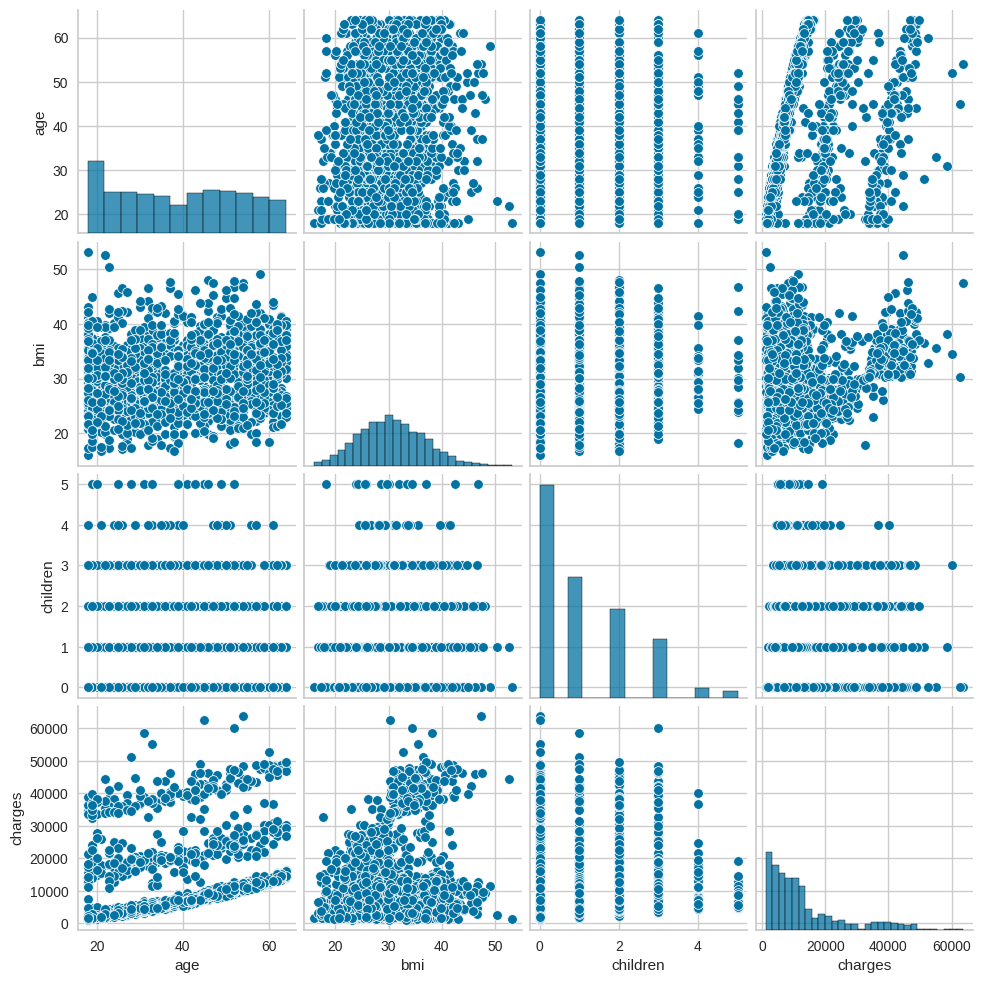

In [11]:
sns.pairplot(df)

# Modeling

In [12]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

In [13]:
X = df[FEATURES]
y = df[TARGET]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
numerical_transformer = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# categorical_transformer = OneHotEncoder(drop='if_binary', 
#                                         handle_unknown='ignore',
#                                         sparse_output=False)
categorical_transformer = OrdinalEncoder(
    handle_unknown='use_encoded_value',  # Handle unknown categories
    unknown_value=-1  # Assign -1 to unknown categories
)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

# Fit the preprocessor on the training data
preprocessor.fit_transform(X_train)

,num__age,num__bmi,num__children,cat__sex,cat__smoker,cat__region
560,0.608696,0.107345,0.4,0.0,0.0,1.0
1285,0.630435,0.224913,0.0,0.0,0.0,0.0
1142,0.739130,0.239440,0.0,0.0,0.0,2.0
969,0.456522,0.493947,1.0,0.0,0.0,2.0
486,0.782609,0.148238,0.6,0.0,0.0,1.0
...,...,...,...,...,...,...
1095,0.000000,0.414044,0.8,0.0,0.0,0.0
1130,0.456522,0.212806,1.0,0.0,0.0,2.0
1294,0.869565,0.247915,0.0,1.0,0.0,0.0
860,0.413043,0.851224,0.4,0.0,1.0,3.0


In [20]:
# Extract the OrdinalEncoder from the ColumnTransformer
categorical_transformer = preprocessor.named_transformers_['cat']

In [21]:
# Retrieve the categories for each categorical feature
encoder_mappings = {}
for i, feature in enumerate(CATEGORICAL_FEATURES):
    encoder_mappings[feature] = categorical_transformer.categories_[i]

In [22]:
# Display the encoder mappings
for feature, categories in encoder_mappings.items():
    print(f"Feature: {feature}")
    print(f"Categories: {categories}")
    print(f"Encoded as: {list(range(len(categories)))}")
    print()

Feature: sex
Categories: ['female' 'male']
Encoded as: [0, 1]

Feature: smoker
Categories: ['no' 'yes']
Encoded as: [0, 1]

Feature: region
Categories: ['northeast' 'northwest' 'southeast' 'southwest']
Encoded as: [0, 1, 2, 3]



In [26]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('inputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', DummyRegressor())])

In [37]:
params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(random_state=42)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('inputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'model': [DummyRegressor(), LinearRegression(),
                                   LassoCV(), RidgeCV(),
                                   RandomForestRegressor(random_state=42),
                                   GradientBoostingRegressor(random_state=42)]},
             scoring='r2', verbose=1)

In [38]:
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('inputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [39]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,
1,GradientBoostingRegressor(random_state=42),{'model': GradientBoostingRegressor(random_sta...,0.840625,0.043270
2,RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},0.826147,0.041004
3,LassoCV(),{'model': LassoCV()},0.734004,0.048281
4,RidgeCV(),{'model': RidgeCV()},0.733958,0.048630
5,LinearRegression(),{'model': LinearRegression()},0.733943,0.048703
6,DummyRegressor(),{'model': DummyRegressor()},-0.004796,0.005035


In [40]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8],
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('inputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

In [41]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.849818,0.040806
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.849341,0.041368
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.848365,0.040673
4,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.848207,0.040126
5,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.847329,0.041283
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.846789,0.040184
7,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.844737,0.041386
8,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.844397,0.040640
9,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.844389,0.041545


In [42]:
model_pipeline = grid_model.best_estimator_

In [43]:
y_pred = model_pipeline.predict(X_test)

In [44]:
get_metrics(y_test, y_pred)

{'R2': 0.8780396079099018,
 'MAE': 2516.4795836659305,
 'MAPE': 0.33798169227200664,
 'RMSE': 4351.344179012627}

<Axes: xlabel='charges'>

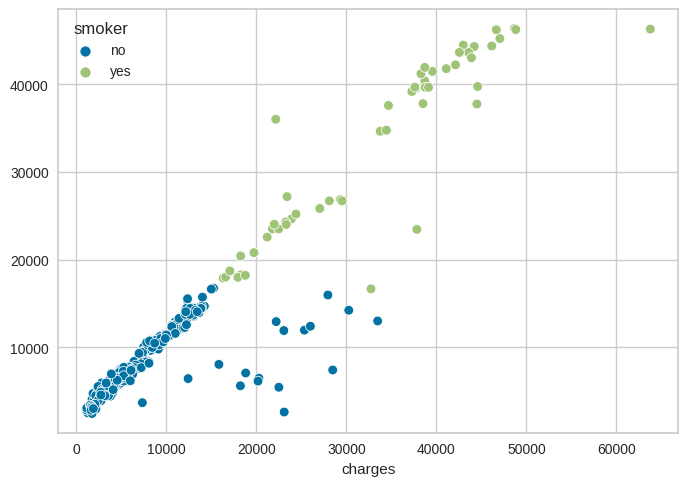

In [45]:
sns.scatterplot(x=y_test, y=y_pred, hue=X_test.smoker)

<Axes: >

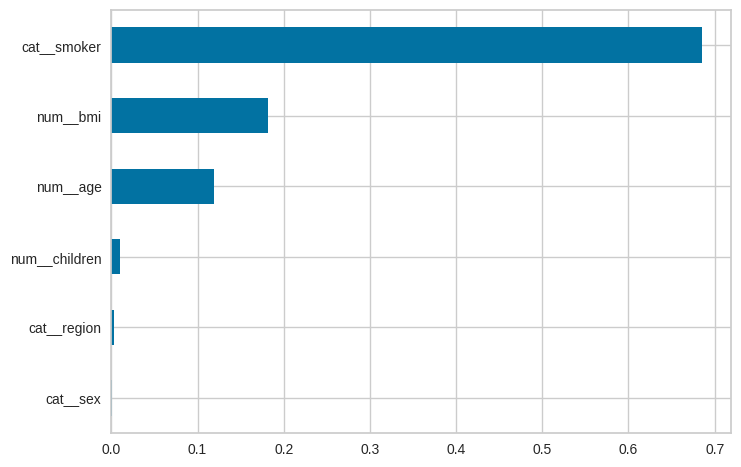

In [52]:
importances = pd.Series(
    data=model_pipeline.named_steps['model'].feature_importances_,
    index=model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [53]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['smoker']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
numerical_transformer = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# categorical_transformer = OneHotEncoder(drop='if_binary', 
#                                         handle_unknown='ignore',
#                                         sparse_output=False)
categorical_transformer = OrdinalEncoder(
    handle_unknown='use_encoded_value',  # Handle unknown categories
    unknown_value=-1  # Assign -1 to unknown categories
)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8],
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('inputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['smoker'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

In [55]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.848911,0.040924
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.848411,0.041504
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.847869,0.040686
4,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.847552,0.040357
5,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.846705,0.041241
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.846031,0.040383
7,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.844021,0.041836
8,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.843724,0.042061
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.843602,0.040359


In [57]:
model_pipeline = grid_model.best_estimator_
y_pred = model_pipeline.predict(X_test)

In [58]:
get_metrics(y_test, y_pred)

{'R2': 0.8773878295835479,
 'MAE': 2509.4963220173236,
 'MAPE': 0.34143644193671197,
 'RMSE': 4362.95586988997}

<Axes: >

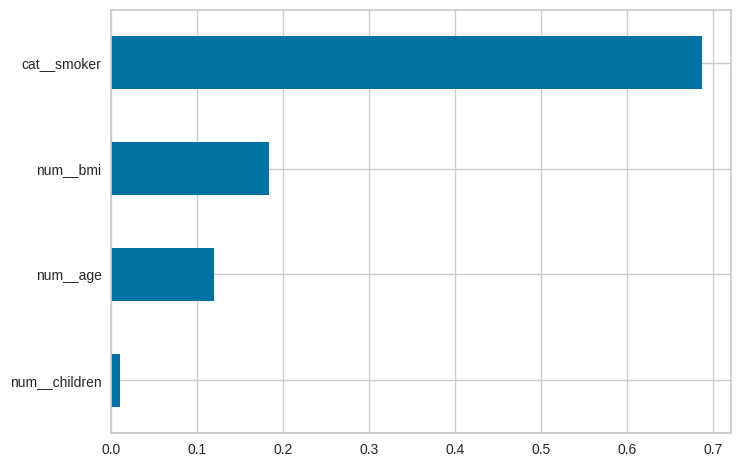

In [59]:
importances = pd.Series(
    data=model_pipeline.named_steps['model'].feature_importances_,
    index=model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [61]:
with open('../models/model.pkl', 'wb') as file_model:
    pickle.dump(model_pipeline, file_model)